# Demonstration of k-means assumptions

## Data generation
- `make_blobs` 함수는 구형 가우시안 blobs를 생성한다.
- 타원형 가우시안 blobs를 얻으려면 선형 변환을 정의해야 한다.

In [1]:
import numpy as np

from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]     # 타원형 클러스터를 생성하기 위한 선형 변환 행렬을 정의한다.

X, y = make_blobs(n_samples=n_samples, random_state=random_state)   # 함수의 기본 매개변수를 사용하여 구형 클러스터를 생성
X_aniso = np.dot(X, transformation)  # 타원형 blobs
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)  # 등분산성: 클러스터의 표준 편차를 다르게 설정하여 등분산 되지 않은 클러스터를 생성한다.
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # 불규칙한 크기의 blobs: 각 클러스터의 샘플 수를 다르게 설정하여 불규칙한 크기의 클러스터를 생성한다.
y_filtered = [0] * 500 + [1] * 100 + [2] * 10

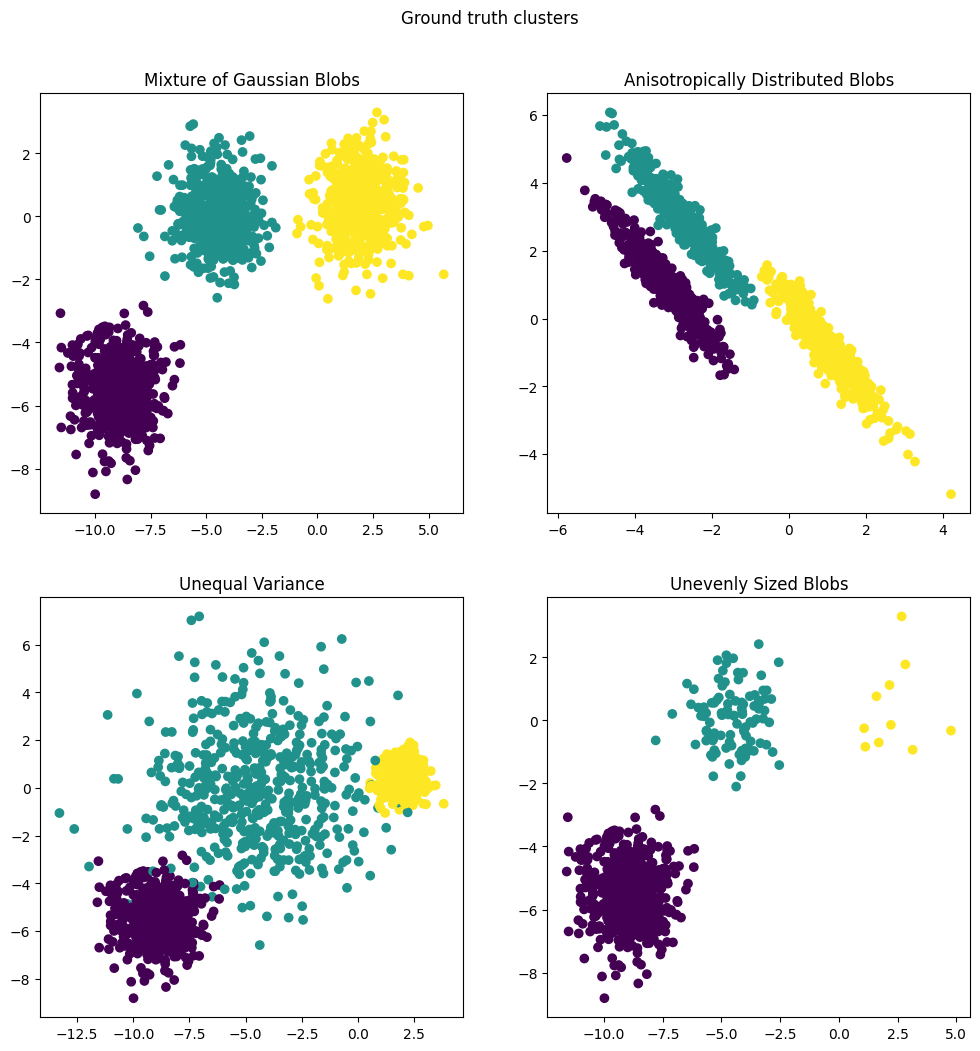

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

axs[0, 0].scatter(X[:, 0], X[:, 1], c=y)
axs[0, 0].set_title("Mixture of Gaussian Blobs")

axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_varied)
axs[1, 0].set_title("Unequal Variance")

axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_filtered)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Ground truth clusters").set_y(0.95)
plt.show()

## Fit models and plot results
- 최적의 클러스터 수
    - 실제 상황에서는 클러스터의 정확한 갯수가 정의되어 있지 않다.
    - 적절한 클러스터의 갯수는 데이터 기반의 기준과 목표에 대한 지식을 토대로 결정
- 타원형으로 분포된 클러스터
    - KMeans는 클러스터에 할당된 샘플들의 중심점까지의 유클리드 거리를 최소화하는 방식으로 구성되어 있다.
    - KMeans는 구형 클러스터에 더 적합하다.
- 등분산성
    - KMeans는 동일한 분산을 가진 k개의 가우시안 분포의 혼합물로 간주될 때 최대 우도 추정치를 사용한다.
    - 분산은 동일하지만 평균은 다를 수 있는 경우에 해당한다.
- 불균일한 크기의 클러스터
    - 유클리드 거리를 최소화한다는 특성으로 문제가 더 희소하고 고차원일수록 알고리즘을 다른 중심으로 실행하여 global minimal inertia를 보장하는 것이 더 필요하다.

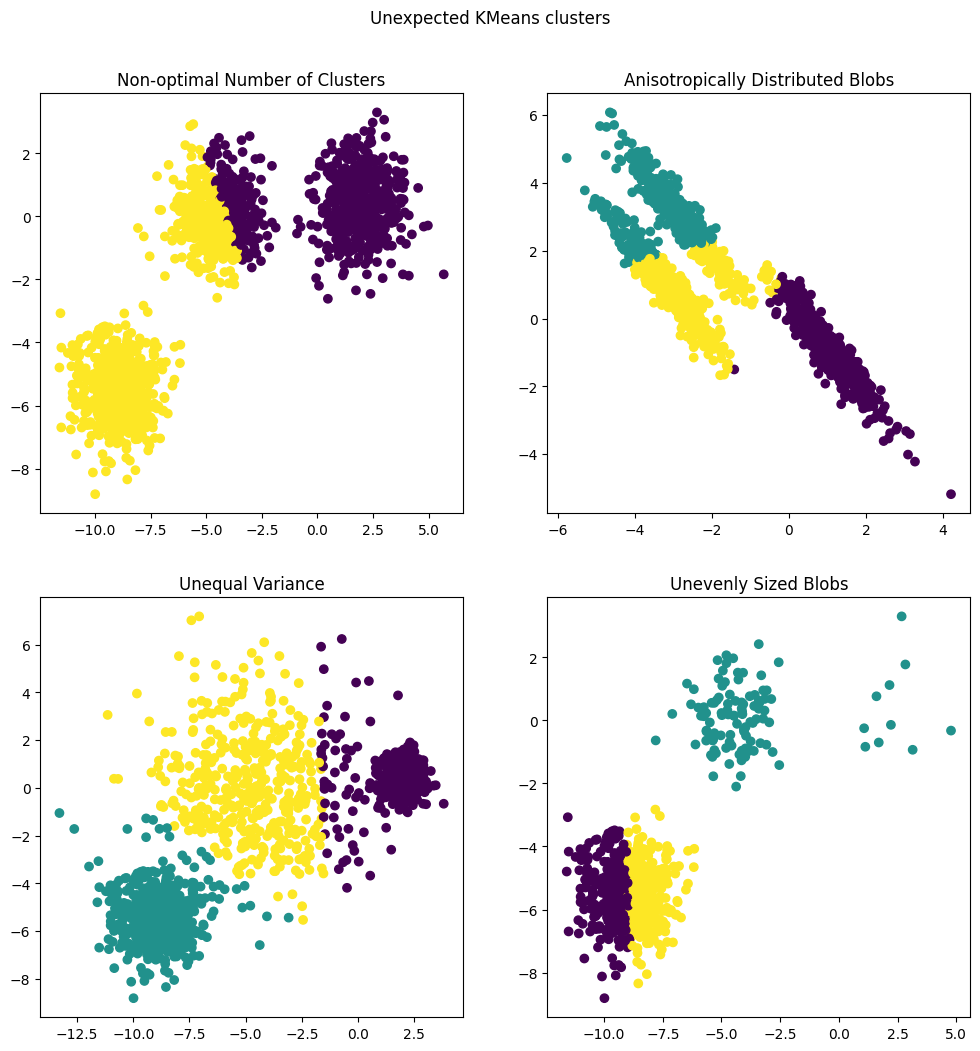

In [3]:
from sklearn.cluster import KMeans

common_params = {
    "n_init": "auto",
    "random_state": random_state,
}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

y_pred = KMeans(n_clusters=2, **common_params).fit_predict(X)
axs[0, 0].scatter(X[:, 0], X[:, 1], c=y_pred)
axs[0, 0].set_title("Non-optimal Number of Clusters")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_aniso)
axs[0, 1].scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
axs[0, 1].set_title("Anisotropically Distributed Blobs")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_varied)
axs[1, 0].scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
axs[1, 0].set_title("Unequal Variance")

y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X_filtered)
axs[1, 1].scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
axs[1, 1].set_title("Unevenly Sized Blobs")

plt.suptitle("Unexpected KMeans clusters").set_y(0.95)
plt.show()

## possible solution

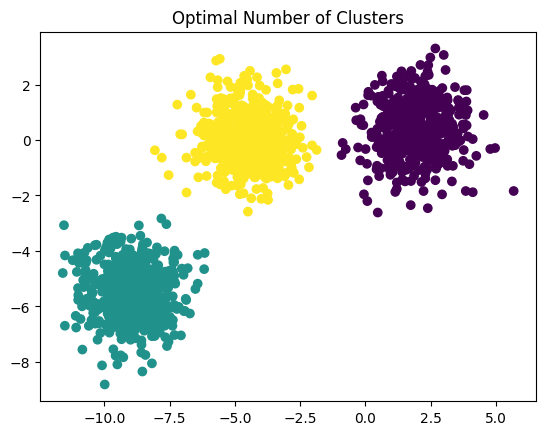

In [4]:
y_pred = KMeans(n_clusters=3, **common_params).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=y_pred)
plt.title("Optimal Number of Clusters")
plt.show()

불균일한 크기의 클러스터를 다루기 위해 `random_state` 횟수를 늘릴 수 있다. 이 경우, 우리는 차선의 local optima를 피하기 위해 `n_init=10`으로 설정했다.

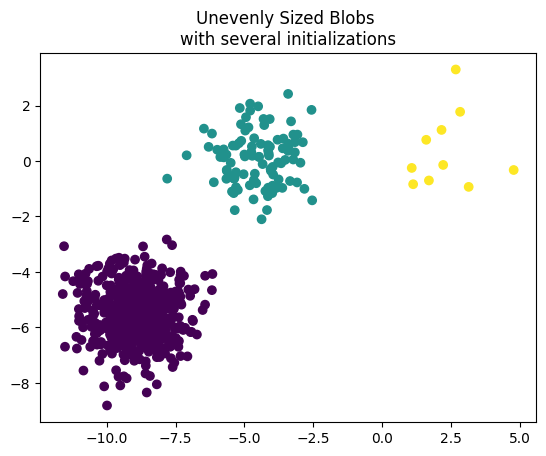

In [5]:
y_pred = KMeans(n_clusters=3, n_init=10, random_state=random_state).fit_predict(
    X_filtered
)
plt.scatter(X_filtered[:, 0], X_filtered[:, 1], c=y_pred)
plt.title("Unevenly Sized Blobs \nwith several initializations")
plt.show()

비등방성과 불균등한 분산은 k-means 알고리즘의 실제적인 한계이므로, 여기서는 GaussianMixture의 사용을 제안한다.
#
GaussianMixture는 가우시안 클러스터를 가정하지만 분산에 어떠한 제약도 부과하지 않는다.

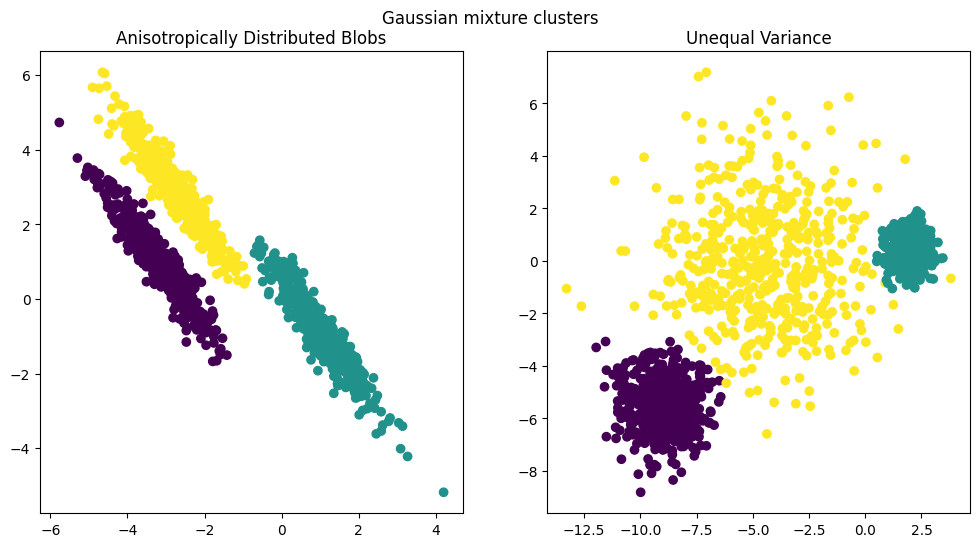

In [6]:
from sklearn.mixture import GaussianMixture

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

y_pred = GaussianMixture(n_components=3).fit_predict(X_aniso)
ax1.scatter(X_aniso[:, 0], X_aniso[:, 1], c=y_pred)
ax1.set_title("Anisotropically Distributed Blobs")

y_pred = GaussianMixture(n_components=3).fit_predict(X_varied)
ax2.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
ax2.set_title("Unequal Variance")

plt.suptitle("Gaussian mixture clusters").set_y(0.95)
plt.show()